In [1]:
import pandas as pd
from tqdm import tqdm
import os
import librosa as lb
import numpy as np
from glob import glob
import shutil
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import splitfolders
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Input, MaxPooling1D, Activation, Permute, Dense, BatchNormalization, Flatten, LSTM, Bidirectional, Dropout, TimeDistributed

Using TensorFlow backend.


In [2]:
file_data = pd.read_csv('file_data.csv')

In [3]:
file_data

,fname,start,end,crack_wheez,fname_cycle
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav
...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav
6894,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav
6895,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav
6896,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav


In [ ]:
for idx, row in file_data.iterrows():
    if row['crack_wheez'] == 0:
        shutil.move('Breath_cycles/'+row['fname_cycle'], 'clean/healthy/')
    if row['crack_wheez'] == 1:
        shutil.move('Breath_cycles/'+row['fname_cycle'], 'clean/crackle/')
    if row['crack_wheez'] == 2:
        shutil.move('Breath_cycles/'+row['fname_cycle'], 'clean/wheeze/')
    if row['crack_wheez'] == 3:
        shutil.move('Breath_cycles/'+row['fname_cycle'], 'clean/both/')

In [4]:
#Define sequence data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, n_classes,
                 batch_size=32, shuffle=True, max_pad_len = 94):
        self.wav_paths = wav_paths
        self.labels = labels
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.max_pad_len = max_pad_len
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, 20, 94), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            #Load wav file and trim if length is more than 6s
            wav,  rate = lb.load(path, sr=None)
            if wav.shape[0] > 24000:
                wav = wav[0:24000]
            #extract mfcc feature
            X_sample = lb.feature.mfcc(wav, sr=rate, n_fft=512,  win_length=400, n_mfcc=20, hop_length = 256, n_mels = 128, fmin = 100, fmax = 1800)
           #pad zeros to match the max length
            pad_width = self.max_pad_len - X_sample.shape[1]
            X_sample = np.pad(X_sample, pad_width=((0, 0), (0, pad_width)), mode='constant')
            X[i,] = X_sample
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [5]:
#define LSTM model with skip connection
def LSTM():
    N_CLASSES=4

    i = layers.Input(shape=(20, 94), name='input')
    x = layers.Permute((2,1), name='permute')(i)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=regularizers.l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
LSTM().summary()

Model: "long_short_term_memory"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 20, 94)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 94, 20)       0           input[0][0]                      
__________________________________________________________________________________________________
td_dense_tanh (TimeDistributed) (None, 94, 64)       1344        permute[0][0]                    
__________________________________________________________________________________________________
bidirectional_lstm (Bidirection (None, 94, 256)      197632      td_dense_tanh[0][0]              
_____________________________________________________________________________

In [7]:
def train():
    csv_path = os.path.join('logs', 'log_history.csv')
    wav_paths = glob('{}/**'.format('clean/'), recursive=True)
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x]
    classes = sorted(os.listdir('clean/'))
    le = LabelEncoder()
    le.fit(classes)
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    labels = le.transform(labels)
    # Split data into train and test sets
    wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                  labels,
                                                                  test_size=0.1,
                                                                  random_state=0)
    #Generate train and test data in batches
    tg = DataGenerator(wav_train, label_train, 4, batch_size=32)
    vg = DataGenerator(wav_val, label_val,  4, batch_size=32)
    
    model = LSTM()
    #Save model checkpoints
    cp = ModelCheckpoint('models/lstm.h5', monitor='val_loss',  save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
    csv_logger = CSVLogger(csv_path, append=False)
    #Fit model
    model.fit(tg, validation_data=vg, epochs=50, verbose=1, workers=2, callbacks=[csv_logger, cp])


In [9]:
train()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 194 steps, validate for 21 steps
Epoch 1/50
193/194 [============================>.] - ETA: 1s - loss: 1.1660 - accuracy: 0.5115
Epoch 00001: val_loss improved from inf to 1.10377, saving model to models/lstm.h5
194/194 [==============================] - 248s 1s/step - loss: 1.1663 - accuracy: 0.5113 - val_loss: 1.1038 - val_accuracy: 0.5655
Epoch 2/50
193/194 [============================>.] - ETA: 0s - loss: 1.1186 - accuracy: 0.5248
Epoch 00002: val_loss improved from 1.10377 to 1.08491, saving model to models/lstm.h5
194/194 [==============================] - 167s 859ms/step - loss: 1.1189 - accuracy: 0.5242 - val_loss: 1.0849 - val_accuracy: 0.5789
Epoch 3/50
193/194 [============================>.] - ETA: 0s - loss: 1.0891 - accuracy: 0.5452
Epoch 00003: val_loss improved from 1.08491 to 1.03096, saving model to models/lstm.h5
194/194 [==============================] - 166s 858ms/step - loss: 1.0878 - accuracy: 0.5457 - 

Epoch 29/50
193/194 [============================>.] - ETA: 0s - loss: 0.6346 - accuracy: 0.7594
Epoch 00029: val_loss did not improve from 0.99026
194/194 [==============================] - 123s 632ms/step - loss: 0.6350 - accuracy: 0.7595 - val_loss: 1.0515 - val_accuracy: 0.5997
Epoch 30/50
193/194 [============================>.] - ETA: 0s - loss: 0.6105 - accuracy: 0.7701
Epoch 00030: val_loss did not improve from 0.99026
194/194 [==============================] - 123s 637ms/step - loss: 0.6114 - accuracy: 0.7695 - val_loss: 1.0530 - val_accuracy: 0.6295
Epoch 31/50
193/194 [============================>.] - ETA: 0s - loss: 0.5872 - accuracy: 0.7772
Epoch 00031: val_loss did not improve from 0.99026
194/194 [==============================] - 123s 634ms/step - loss: 0.5873 - accuracy: 0.7775 - val_loss: 0.9998 - val_accuracy: 0.6533
Epoch 32/50
193/194 [============================>.] - ETA: 0s - loss: 0.5821 - accuracy: 0.7801
Epoch 00032: val_loss did not improve from 0.99026
194

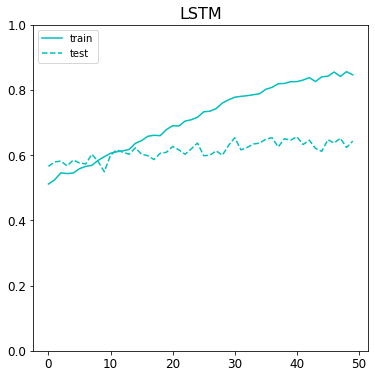

In [14]:

plt.figure(figsize=(6,6))
df = pd.read_csv('logs/log_history.csv')
plt.title('LSTM', size=16)
plt.plot(df.accuracy, color='c', label='train')
plt.plot(df.val_accuracy, ls='--', color='c', label='Validation')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.0])


plt.show()